# How relevant are the forcefield and solvent conditions if just a not-very-stressed structure want to be obtained with a minimization

The original model was minimized with Charmm22. This structure will be the starting point for 6 minizations with two forcefields and three different solvent conditions:

- Charmm36 in vacuum
- Charmm36 in implicit solvent
- Charmm36 in a TIP3P water box
- Amber14 in vacuum
- Amber14 in implicit solvent
- Amber14 in a TIP3P water box

## Importing libraries

In [51]:
import os
import simtk.openmm.app as app
import simtk.openmm as mm
import simtk.unit as unit
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
import numpy as np
from sklearn.manifold import MDS

## Preparing file and directory

Lets create a directory to place the pdb files of the minimized structures

In [9]:
PDBs_experiments_dirpath = './PDBs_experiments'
os.mkdir(PDBs_experiments_dirpath)

Lets copy there the original structure minimized with Charmm22 in vacuum:

In [10]:
os.listdir(PDBs_experiments_dirpath)

['Charmm22_vacuum.pdb']

## Loading the original model of the manuscript first version

In [12]:
pdb =app.PDBFile(PDBs_experiments_dirpath+"/Charmm22_vacuum.pdb")

## Producing minimized structures with different forcefields and solvent conditions

In [4]:
experiments={
    'Amber14_vacuum': [["amber14-all.xml"], 'vacuum'],
    'Amber14_implicit': [["amber14-all.xml"], 'implicit'],
    'Amber14_explicit': [["amber14-all.xml", "amber14/tip3p.xml"], 'explicit'],
    'Charmm36_vacuum': [["charmm36.xml"], 'vacuum'],
    'Charmm36_implicit': [["charmm36.xml"], 'implicit'],
    'Charmm36_explicit': [["charmm36.xml","charmm36/water.xml"], 'explicit'],
}

In [5]:
vacuum_parameters={
    'nonbondedMethod': app.NoCutoff,
    'constraints': app.HBonds
}

implicit_parameters={
    'nonbondedMethod': app.NoCutoff,
    'constraints': app.HBonds,
    'implicitSolvent': app.OBC2
}

explicit_parameters={
    'nonbondedMethod': app.PME,
    'nonbondedCutoff': 1*unit.nanometer,
    'constraints': app.HBonds
}

In [6]:
verbose = True

for experiment, conditions in experiments.items():
    
    if verbose:
        print("Doing experiment: {}".format(experiment))
    
    list_forcefield_files = conditions[0]
    solvent = conditions[1]
    
    topology = pdb.topology
    positions = pdb.positions
    
    # Forcefield
    
    forcefield =app.ForceField(*list_forcefield_files)
    
    # Adding solvent if experiment is explicit
    
    if solvent=='explicit':
        
        modeller = app.Modeller(pdb.topology, pdb.positions)
        modeller.addSolvent(forcefield, padding=1.4*unit.nanometers)
        
        topology = modeller.topology
        positions = modeller.positions
    
    # Creating system
    
    creation_parameters = None
    
    if solvent=='vacuum':
        creation_parameters = vacuum_parameters
    elif solvent=='implicit':
        creation_parameters = implicit_parameters
    elif solvent=='explicit':
        creation_parameters = explicit_parameters
    
    system = forcefield.createSystem(topology, **creation_parameters)
    
    # Integrator
    
    integrator = mm.LangevinIntegrator(0*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    integrator.setConstraintTolerance(0.00001)
    
    # Platform
    
    platform = mm.Platform.getPlatformByName('CPU')
    #properties = {'CudaPrecision': 'mixed'}
    properties = {}
    
    # Simulation
    
    simulation = app.Simulation(topology, system, integrator, platform, properties)
    simulation.context.setPositions(positions)
    
    # Minimization
    
    if verbose:
        Edo_PreMin = simulation.context.getState(getEnergy = True)
        E = Edo_PreMin.getPotentialEnergy()
        print(E)
    
    if verbose:
        print('Minimizing...')
    
    simulation.minimizeEnergy(tolerance=0.1*unit.kilojoule/unit.mole, maxIterations=500)
    
    Edo_PosMin = simulation.context.getState(getEnergy = True, getPositions = True)
    
    if verbose:
        E = Edo_PosMin.getPotentialEnergy()
        print(E)
    
    positions_min = Edo_PosMin.getPositions()
    
    # Saving the minimized system in new pdb file
    
    pdbfile_path = PDBs_experiments_dir_path+'/'+experiment+'.pdb'
    app.PDBFile.writeFile(topology, positions_min, open(pdbfile_path, 'w'))
    
    if verbose:
        print('... Done')
        print(' ')

Doing experiment: Amber14_vacuum
9145.484760688047 kJ/mol
Minimizing...
-6170.5754833085175 kJ/mol
... Done
 
Doing experiment: Amber14_implicit
9145.484760688047 kJ/mol
Minimizing...
-6171.304274904447 kJ/mol
... Done
 
Doing experiment: Amber14_explicit
-182224.7882950883 kJ/mol
Minimizing...
-458405.1996078836 kJ/mol
... Done
 
Doing experiment: Charmm36_vacuum
7386.410383416282 kJ/mol
Minimizing...
-7297.783076738622 kJ/mol
... Done
 
Doing experiment: Charmm36_implicit
7386.41038341628 kJ/mol
Minimizing...
-7319.719149742587 kJ/mol
... Done
 
Doing experiment: Charmm36_explicit
-141523.55873378782 kJ/mol
Minimizing...
-479274.6812168473 kJ/mol
... Done
 


## RMSD Comparison

Lets load all molecular systems with mdtraj to work with them:

In [13]:
PDBs_experiments = os.listdir(PDBs_experiments_dirpath)

md_objects_experiments = {}

for PDB_experiment in PDBs_experiments:
    name_experiment = PDB_experiment.split('.')[0]
    md_objects_experiments[name_experiment]=md.load(PDBs_experiments_dirpath+'/'+PDB_experiment)

In [59]:
names_experiments = list(md_objects_experiments.keys())
n_experiments = len(names_experiments)

In [15]:
print(names_experiments)

['Charmm22_vacuum', 'Amber14_vacuum', 'Charmm36_implicit', 'Amber14_explicit', 'Amber14_implicit', 'Charmm36_explicit', 'Charmm36_vacuum']


In [16]:
print(md_objects_experiments['Amber14_vacuum'])

<mdtraj.Trajectory with 1 frames, 764 atoms, 43 residues, without unitcells>


Lets remove the solvent molecules in those system solvated with explicit water molecules:

In [22]:
for experiment in ['Amber14_explicit', 'Charmm36_explicit']:
    md_object = md_objects_experiments[experiment]
    md_objects_experiments[experiment] = md_object.remove_solvent()
    md_objects_experiments[experiment].unitcell_vectors=None

### RMSD with backbone

Lets calculate now the least RMSD of every pair of systems only with the backbone atoms:

In [241]:
verbose = True

list_selection = md_objects_experiments["Charmm22_vacuum"].topology.select("backbone")

lrmsd_matrix = np.zeros([n_experiments, n_experiments], dtype=float)*unit.angstroms

for ii in range(0,n_experiments):
    experiment_i = names_experiments[ii]
    for jj in range(ii+1,n_experiments):
        experiment_j = names_experiments[jj]
        
        if verbose:
            print('{} vs. {}:'.format(experiment_i, experiment_j))

        md_object_i = md_objects_experiments[experiment_i]
        md_object_j = md_objects_experiments[experiment_j]

        lrmsd = md.lprmsd(md_object_i, md_object_j, atom_indices = list_selection)[0]*unit.nanometers
        lrmsd_matrix[ii, jj]=lrmsd
        lrmsd_matrix[jj, ii]=lrmsd

        if verbose:
            print('          ... least rmsd is {}'.format(lrmsd_matrix[ii,jj]))

Charmm22_vacuum vs. Amber14_vacuum:
          ... least rmsd is 1.4050698280334473 A
Charmm22_vacuum vs. Charmm36_implicit:
          ... least rmsd is 1.4407385885715485 A
Charmm22_vacuum vs. Amber14_explicit:
          ... least rmsd is 1.0094042122364044 A
Charmm22_vacuum vs. Amber14_implicit:
          ... least rmsd is 1.422295719385147 A
Charmm22_vacuum vs. Charmm36_explicit:
          ... least rmsd is 0.7422711700201035 A
Charmm22_vacuum vs. Charmm36_vacuum:
          ... least rmsd is 1.4453125 A
Amber14_vacuum vs. Charmm36_implicit:
          ... least rmsd is 0.786207914352417 A
Amber14_vacuum vs. Amber14_explicit:
          ... least rmsd is 1.252899318933487 A
Amber14_vacuum vs. Amber14_implicit:
          ... least rmsd is 0.11748991906642914 A
Amber14_vacuum vs. Charmm36_explicit:
          ... least rmsd is 1.190560832619667 A
Amber14_vacuum vs. Charmm36_vacuum:
          ... least rmsd is 0.7936761528253555 A
Charmm36_implicit vs. Amber14_explicit:
          ... least 

All least rmsds are in an acceptable range. Let see the maximum least rmsd observed:

In [242]:
max_pair = np.unravel_index(np.argmax(lrmsd_matrix), lrmsd_matrix.shape)
max_least_rmsd = lrmsd_matrix[max_pair]
print('Maximum least rmsd between {} and {}: {}'.format(names_experiments[max_pair[0]],
                                                        names_experiments[max_pair[1]],
                                                        max_least_rmsd))

Maximum least rmsd between Charmm22_vacuum and Charmm36_vacuum: 1.4453125 A


A multidimensional scaling analysis allows us to see how far or close are the structures when the dissimilarity is given by the least rmsd:

In [243]:
mds2d = MDS(n_components=2, dissimilarity='precomputed')
embedded_coordinates = mds2d.fit_transform(lrmsd_matrix)

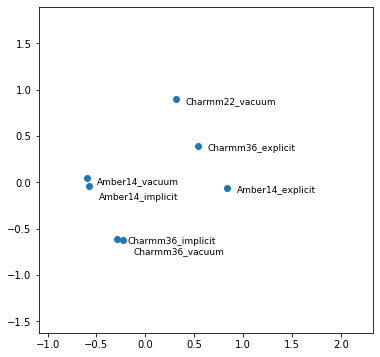

In [244]:
plt.rcParams['figure.figsize'] = [6, 6]

plt.scatter(embedded_coordinates[:,0], embedded_coordinates[:,1])
for ii in range(n_experiments):
    txt = names_experiments[ii]
    if txt not in ['Amber14_implicit', 'Charmm36_vacuum']:
        plt.text(embedded_coordinates[ii,0]+0.1, embedded_coordinates[ii,1]-0.05,
                 txt, fontsize=9)
    else:
        plt.text(embedded_coordinates[ii,0]+0.1, embedded_coordinates[ii,1]-0.15,
                 txt, fontsize=9)
        
plt.xlim([embedded_coordinates[:,0].min()-0.5, embedded_coordinates[:,0].max()+1.5])
plt.ylim([embedded_coordinates[:,1].min()-1.0, embedded_coordinates[:,1].max()+1.0])
        
plt.show()

The original "Charmm22_vacuum" structure is closer to those minimization in explicit solvent than to the other systems in vacuum or implicit solvent.

Lets see now the structures fitted (with least rmsd) to the "Charmm22_vacuum" coordinates:

In [245]:
for name_experiment in md_objects_experiments:
    md_objects_experiments[name_experiment].superpose(md_objects_experiments['Charmm22_vacuum'],
                                                     atom_indices=list_selection)

In [246]:
view = nv.NGLWidget()

for ii in range(n_experiments):
    name_experiment = names_experiments[ii]
    view.add_trajectory(md_objects_experiments[name_experiment])

view

NGLWidget()

In [247]:
view.render_image()

Image(value=b'', width='99%')

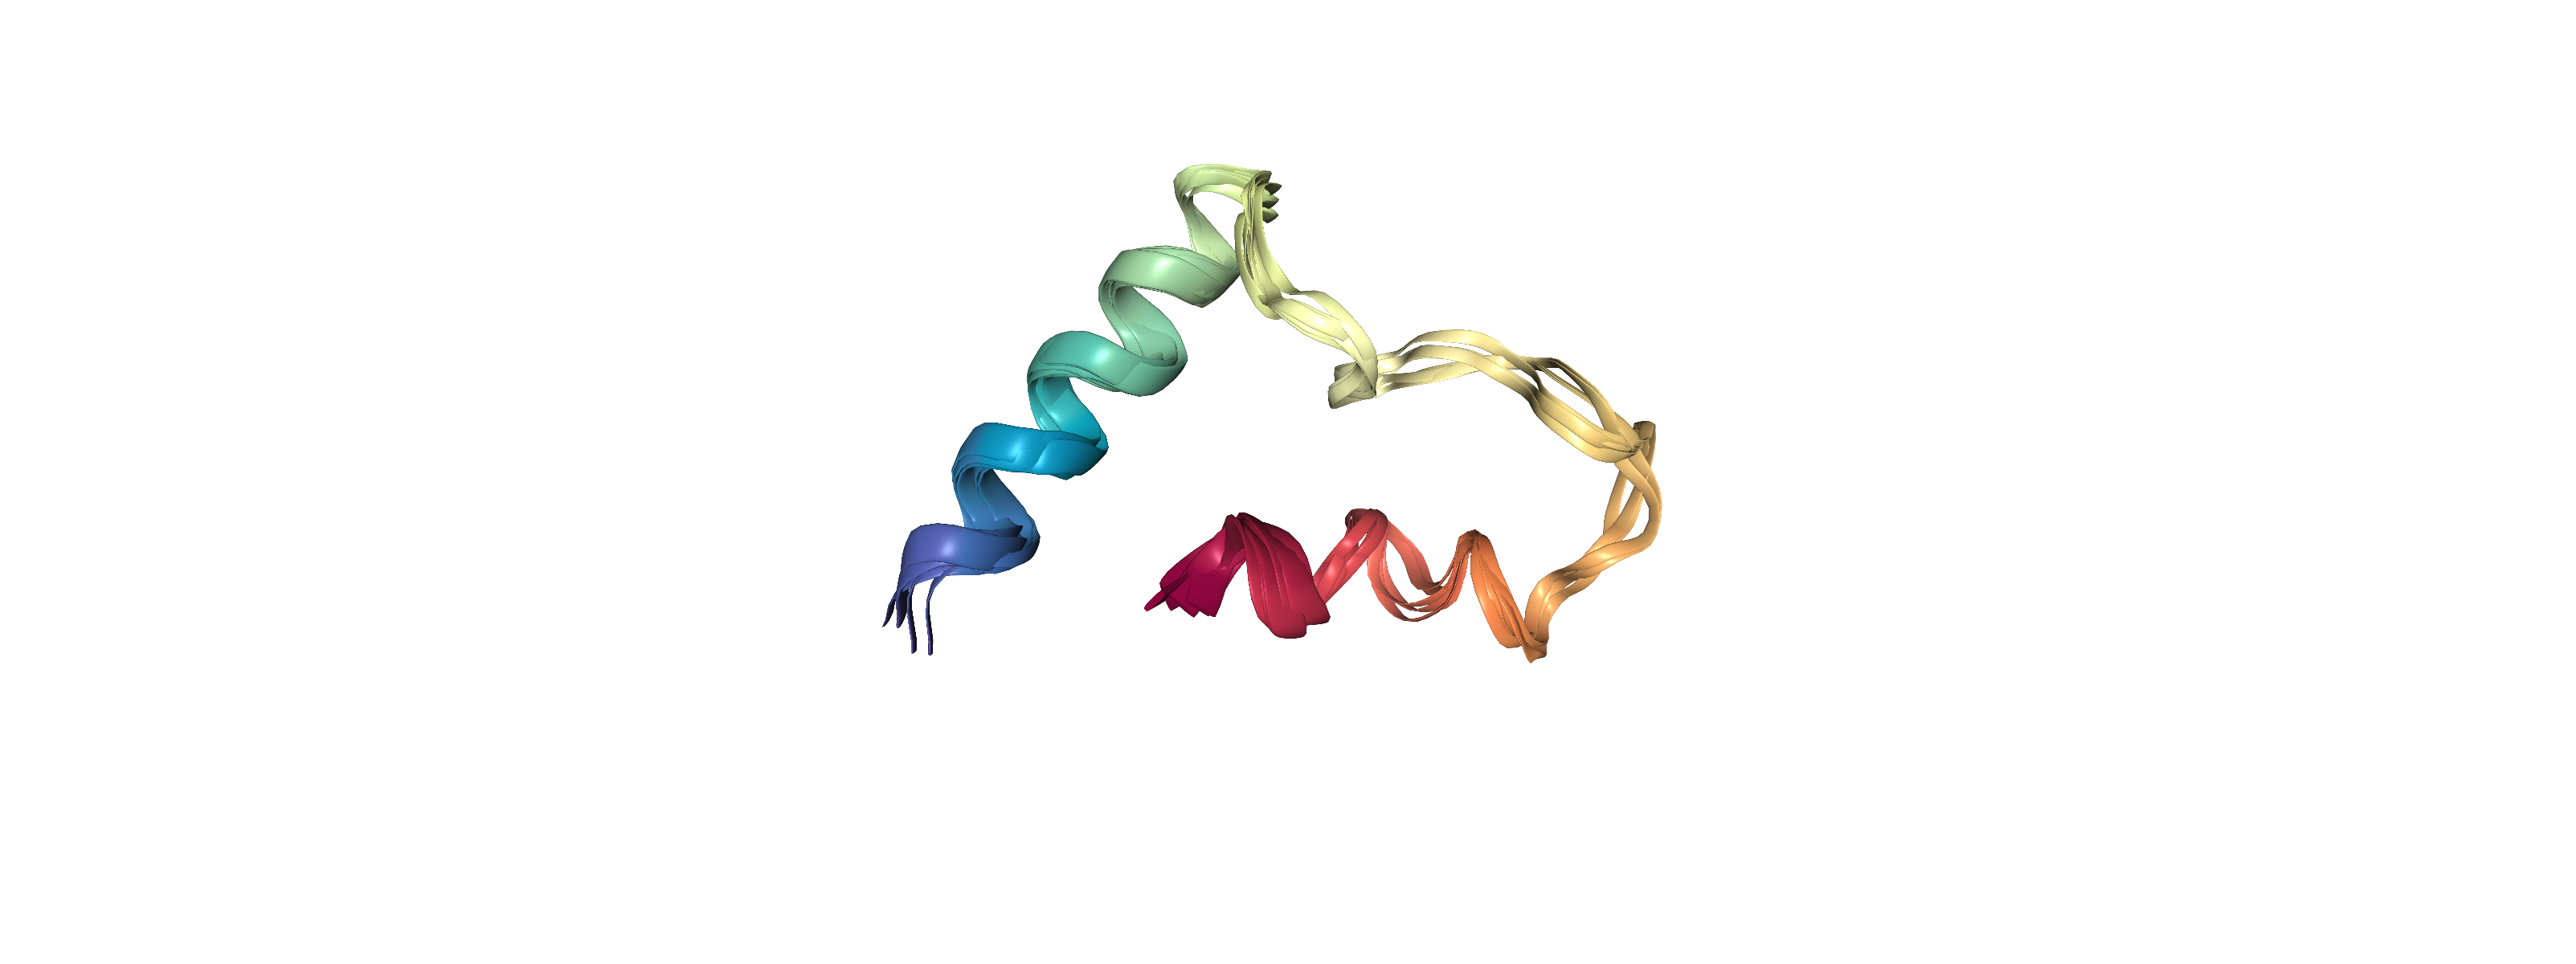

In [248]:
view._display_image()

### Least RMSD with heavy atoms

Lets calculate now the least RMSD of every pair of systems with the set of heavy atoms:

In [226]:
verbose = True

list_selection = md_objects_experiments["Charmm22_vacuum"].topology.select("type!=H")

lrmsd_matrix = np.zeros([n_experiments, n_experiments], dtype=float)*unit.angstroms

for ii in range(0,n_experiments):
    experiment_i = names_experiments[ii]
    for jj in range(ii+1,n_experiments):
        experiment_j = names_experiments[jj]
        
        if verbose:
            print('{} vs. {}:'.format(experiment_i, experiment_j))

        md_object_i = md_objects_experiments[experiment_i]
        md_object_j = md_objects_experiments[experiment_j]

        lrmsd = md.lprmsd(md_object_i, md_object_j, atom_indices = list_selection)[0]*unit.nanometers
        lrmsd_matrix[ii, jj]=lrmsd
        lrmsd_matrix[jj, ii]=lrmsd

        if verbose:
            print('          ... least rmsd is {}'.format(lrmsd_matrix[ii,jj]))

Charmm22_vacuum vs. Amber14_vacuum:
          ... least rmsd is 1.7650936543941498 A
Charmm22_vacuum vs. Charmm36_implicit:
          ... least rmsd is 1.7314033210277557 A
Charmm22_vacuum vs. Amber14_explicit:
          ... least rmsd is 1.1865446716547012 A
Charmm22_vacuum vs. Amber14_implicit:
          ... least rmsd is 1.7768025398254395 A
Charmm22_vacuum vs. Charmm36_explicit:
          ... least rmsd is 0.9008567035198212 A
Charmm22_vacuum vs. Charmm36_vacuum:
          ... least rmsd is 1.7291755974292755 A
Amber14_vacuum vs. Charmm36_implicit:
          ... least rmsd is 0.931156575679779 A
Amber14_vacuum vs. Amber14_explicit:
          ... least rmsd is 1.665441244840622 A
Amber14_vacuum vs. Amber14_implicit:
          ... least rmsd is 0.1784226857125759 A
Amber14_vacuum vs. Charmm36_explicit:
          ... least rmsd is 1.659005731344223 A
Amber14_vacuum vs. Charmm36_vacuum:
          ... least rmsd is 0.933791995048523 A
Charmm36_implicit vs. Amber14_explicit:
          ..

Again the least rmsds observed are in an acceptable range:

In [227]:
max_pair = np.unravel_index(np.argmax(lrmsd_matrix), lrmsd_matrix.shape)
max_least_rmsd = lrmsd_matrix[max_pair]
print('Maximum least rmsd between {} and {}: {}'.format(names_experiments[max_pair[0]],
                                                        names_experiments[max_pair[1]],
                                                        max_least_rmsd))

Maximum least rmsd between Charmm22_vacuum and Amber14_implicit: 1.7768025398254395 A


Let see how the structures are placed in a 2D embedded multidimensional scaling space:

In [229]:
mds2d = MDS(n_components=2, dissimilarity='precomputed')
embedded_coordinates = mds2d.fit_transform(lrmsd_matrix)

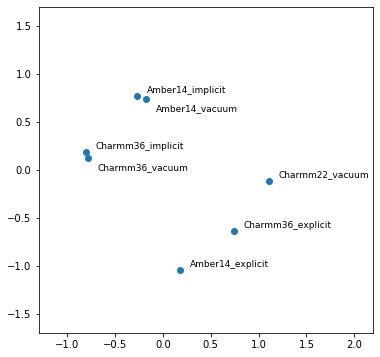

In [236]:
plt.rcParams['figure.figsize'] = [6, 6]

plt.scatter(embedded_coordinates[:,0], embedded_coordinates[:,1])
for ii in range(n_experiments):
    txt = names_experiments[ii]
    if txt not in ['Amber14_vacuum', 'Charmm36_vacuum']:
        plt.text(embedded_coordinates[ii,0]+0.1, embedded_coordinates[ii,1]+0.04,
                 txt, fontsize=9)
    else:
        plt.text(embedded_coordinates[ii,0]+0.1, embedded_coordinates[ii,1]-0.12,
                 txt, fontsize=9)
        
plt.xlim([-1.3,2.2])
plt.ylim([-1.7,1.7])
        
plt.show()

Again the "Charmm22_vacuum" structure is closer to the explicit water systems than to those in vacuum or implicit solvent.

Lets see now the structures fitted over "Charmm22_vacuum" this time with the least rmsd of all heavy atoms:

In [237]:
for name_experiment in md_objects_experiments:
    md_objects_experiments[name_experiment].superpose(md_objects_experiments['Charmm22_vacuum'],
                                                     atom_indices=list_selection)

In [238]:
view = nv.NGLWidget()

for ii in range(n_experiments):
    name_experiment = names_experiments[ii]
    view.add_trajectory(md_objects_experiments[name_experiment])

view

NGLWidget()

In [239]:
view.render_image()

Image(value=b'', width='99%')

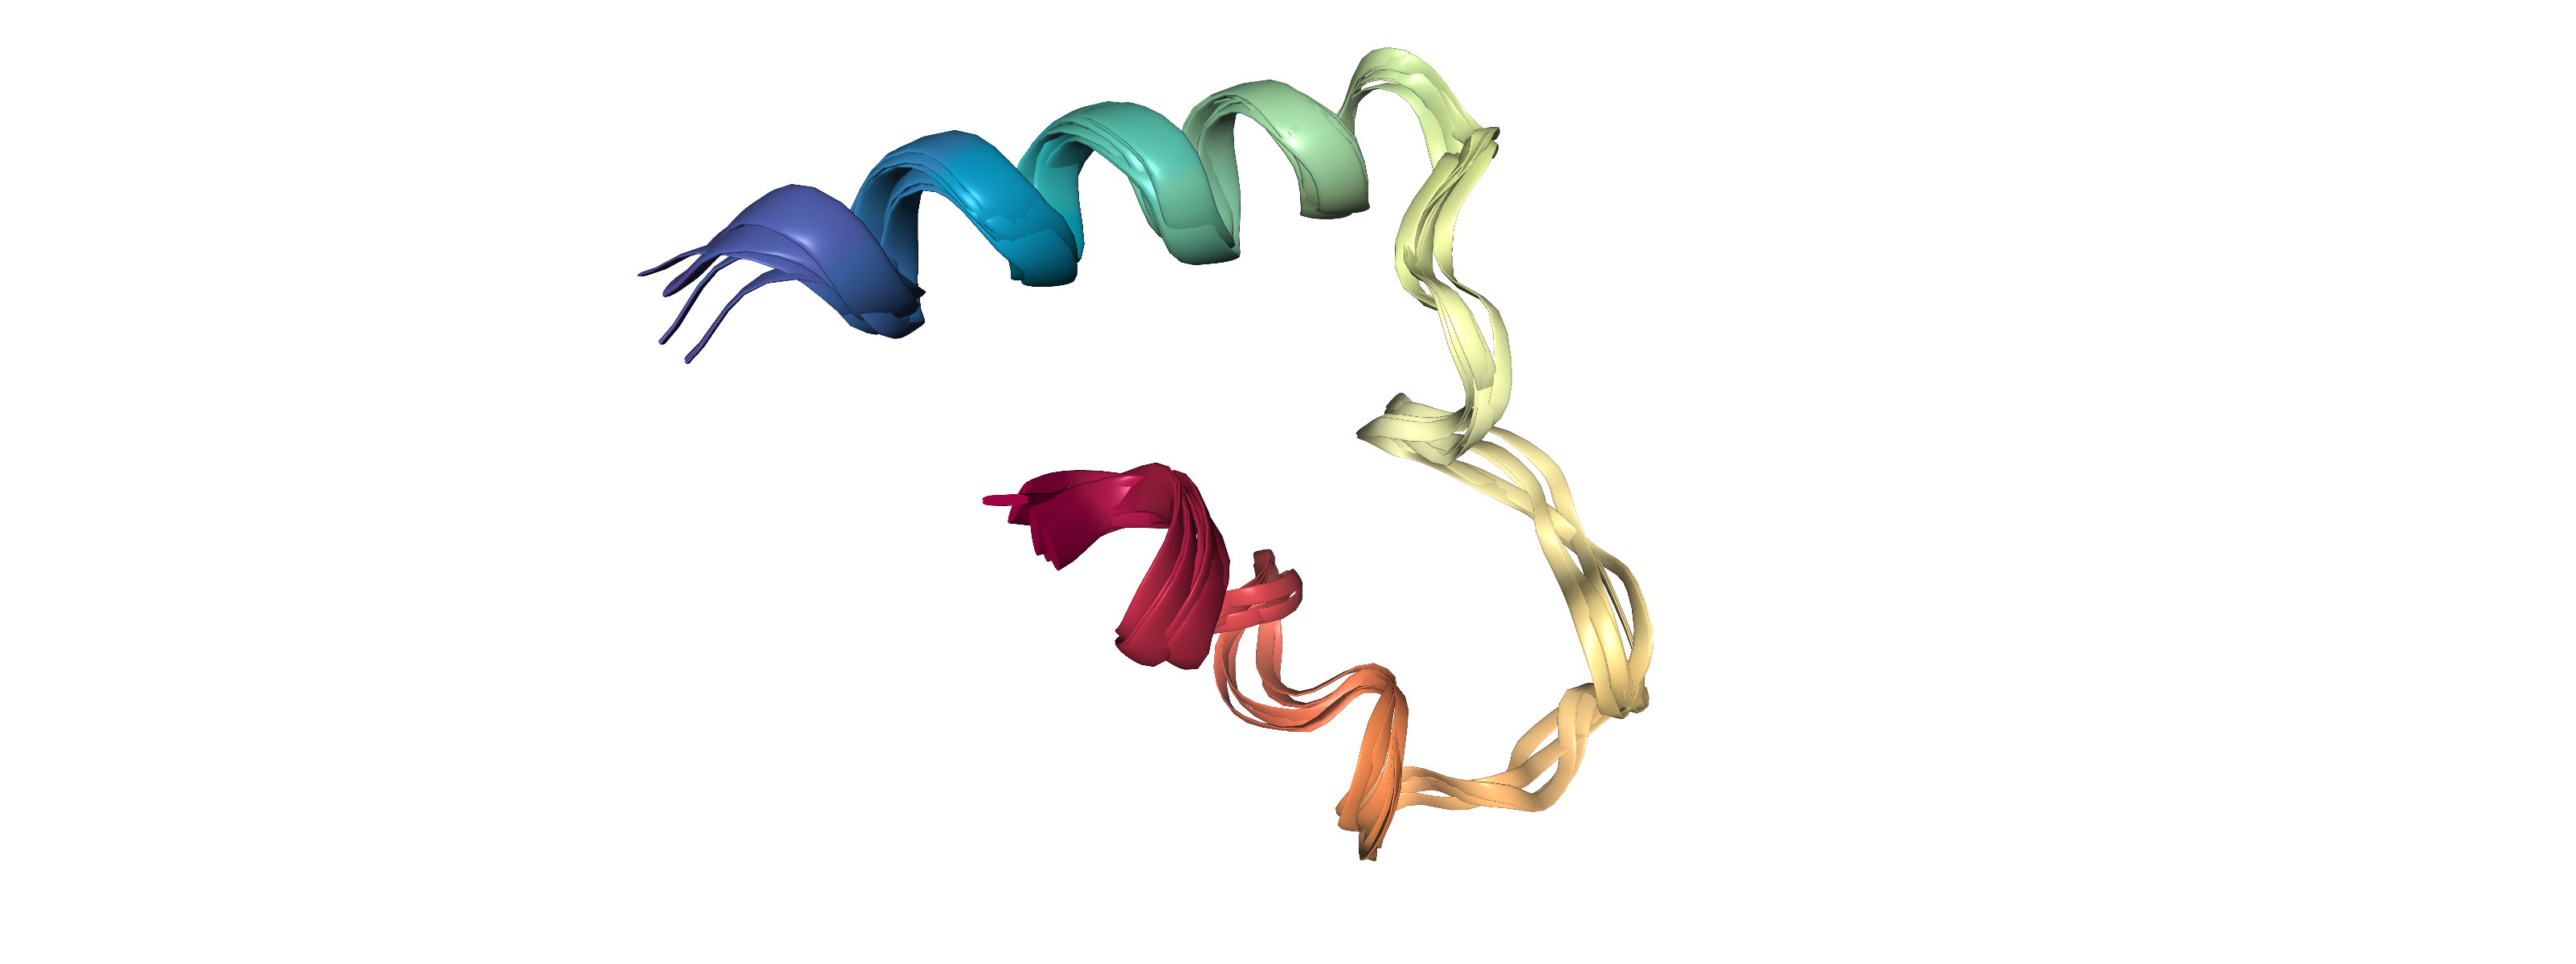

In [240]:
view._display_image()

## Conclusion

- The forcefield and solvent conditions do not affect much when a not-stressed geometry wants to be obtained for the purpose of showing the structure obtained by modeling.